In [3]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [56]:
def unique_values(df):
    """
    Get distinct values and number of them in a dataframe
    :param df: Dataframe to check
    :return: Df with list and count of unique values
    """
    values = df.apply(lambda col: col.unique())
    counts = df.apply(lambda col: col.nunique())
    resumen = pd.concat([values, counts], axis=1)
    return (resumen)


def remove_rows_with_na(df, proportion):
    """
    Function to remove rows with more than a specified proportion of Nans
    :param df:
    :param proportion: 
    :return: df without those rows and df of rows removed
    """
    df_copy = df.copy()
    rows_to_rm = (df.isnull().sum(axis=1) / len(df.columns.tolist())) > proportion
    result = df_copy[~rows_to_rm]
    removed = df_copy[rows_to_rm]
    return result, removed


def variables_distribution_plots(df, vars_to_skip):
    """
    Create barplots for categorical  variables
    :param df: Dataframe with variables to plot
    :param cols_to_skip: list of columns that shouldnt be plotted
    :return: Nothing. Plots 
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for c in list(df.columns):
        if (df[c].dtype in numerics) and (c not in vars_to_skip):
            sns.set()
            fig, axs = plt.subplots(ncols=2, figsize= (10,5))
            fig.suptitle('Variable distribution')
            sns.ecdfplot(data=df, x=c, ax = axs[0])
            sns.boxplot(x=c, data=df, ax = axs[1])
        
        
def cap_outliers_percentiles(df,vars_to_skip, perc1=10, perc2=90):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_result = df.copy()
    
    for c in list(df_result.columns):
        if (df_result[c].dtype in numerics) and (c not in vars_to_skip):
            # Computing 10th, 90th percentiles and replacing the outliers
            floor_percentile = np.nanpercentile(df_result[c], perc1)
            cap_percentile = np.nanpercentile(df_result[c], perc2)
            # print(tenth_percentile, ninetieth_percentile)b = np.where(sample<tenth_percentile, tenth_percentile, sample)
            df_result[c] = np.where(df_result[c] > cap_percentile, cap_percentile, df_result[c])
            df_result[c] = np.where(df_result[c] < floor_percentile, floor_percentile, df_result[c])
    
    return df_result

Database Schema

<img src="C:\Users\Diego\Desktop\Competitions_datacamp\data\credit_data\Database_schema.JPG">

First, analyze bureau and bureau_balance

In [5]:
bureau = pd.read_csv(r"data\credit_data\bureau.csv")

In [4]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [6]:
# Lets rename some columns to make them more readable
bureau = bureau.rename(columns={"SK_ID_CURR": "loan_id_now",
                       "SK_ID_BUREAU": "loan_id_past",
                       "DAYS_CREDIT": "now_minus_first_application",
                       "CNT_CREDIT_PROLONG": "times_prolongued_credit_bureau"})

In [5]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   loan_id_now                     int64  
 1   loan_id_past                    int64  
 2   CREDIT_ACTIVE                   object 
 3   CREDIT_CURRENCY                 object 
 4   now_minus_first_application     int64  
 5   CREDIT_DAY_OVERDUE              int64  
 6   DAYS_CREDIT_ENDDATE             float64
 7   DAYS_ENDDATE_FACT               float64
 8   AMT_CREDIT_MAX_OVERDUE          float64
 9   times_prolongued_credit_bureau  int64  
 10  AMT_CREDIT_SUM                  float64
 11  AMT_CREDIT_SUM_DEBT             float64
 12  AMT_CREDIT_SUM_LIMIT            float64
 13  AMT_CREDIT_SUM_OVERDUE          float64
 14  CREDIT_TYPE                     object 
 15  DAYS_CREDIT_UPDATE              int64  
 16  AMT_ANNUITY                     float64
dtypes: float64(8), int64(6), ob

In [6]:
unique_values(bureau)

,0,1
loan_id_now,"[215354, 162297, 402440, 238881, 222183, 42615...",305811
loan_id_past,"[5714462, 5714463, 5714464, 5714465, 5714466, ...",1716428
CREDIT_ACTIVE,"[Closed, Active, Sold, Bad debt]",4
CREDIT_CURRENCY,"[currency 1, currency 2, currency 4, currency 3]",4
now_minus_first_application,"[-497, -208, -203, -629, -273, -43, -1896, -11...",2923
CREDIT_DAY_OVERDUE,"[0, 2603, 6, 30, 2156, 496, 186, 2264, 41, 8, ...",942
DAYS_CREDIT_ENDDATE,"[-153.0, 1075.0, 528.0, nan, 1197.0, 27460.0, ...",14096
DAYS_ENDDATE_FACT,"[-153.0, nan, -1710.0, -840.0, -825.0, -187.0,...",2917
AMT_CREDIT_MAX_OVERDUE,"[nan, 77674.5, 0.0, 14985.0, 310.5, 20493.27, ...",68251
times_prolongued_credit_bureau,"[0, 2, 1, 4, 3, 5, 9, 8, 6, 7]",10


In [8]:
# Get proportion of NA per row.
# If the proportion is bigger than 0.5, we can remove that row
bureau.isnull().sum(axis=1) / len(bureau.columns.tolist())

0          0.176471
1          0.235294
2          0.294118
3          0.352941
4          0.235294
             ...   
1716423    0.117647
1716424    0.058824
1716425    0.235294
1716426    0.117647
1716427    0.235294
Length: 1716428, dtype: float64

In [7]:
# Lets remove those rows with that problem
bureau, removed = remove_rows_with_na(bureau, 0.5)

In [8]:
# Get proportion of NA per column
bureau.isna().sum()/len(bureau)

loan_id_now                       0.000000
loan_id_past                      0.000000
CREDIT_ACTIVE                     0.000000
CREDIT_CURRENCY                   0.000000
now_minus_first_application       0.000000
CREDIT_DAY_OVERDUE                0.000000
DAYS_CREDIT_ENDDATE               0.061496
DAYS_ENDDATE_FACT                 0.369170
AMT_CREDIT_MAX_OVERDUE            0.655133
times_prolongued_credit_bureau    0.000000
AMT_CREDIT_SUM                    0.000008
AMT_CREDIT_SUM_DEBT               0.150119
AMT_CREDIT_SUM_LIMIT              0.344774
AMT_CREDIT_SUM_OVERDUE            0.000000
CREDIT_TYPE                       0.000000
DAYS_CREDIT_UPDATE                0.000000
AMT_ANNUITY                       0.714735
dtype: float64

<AxesSubplot:>

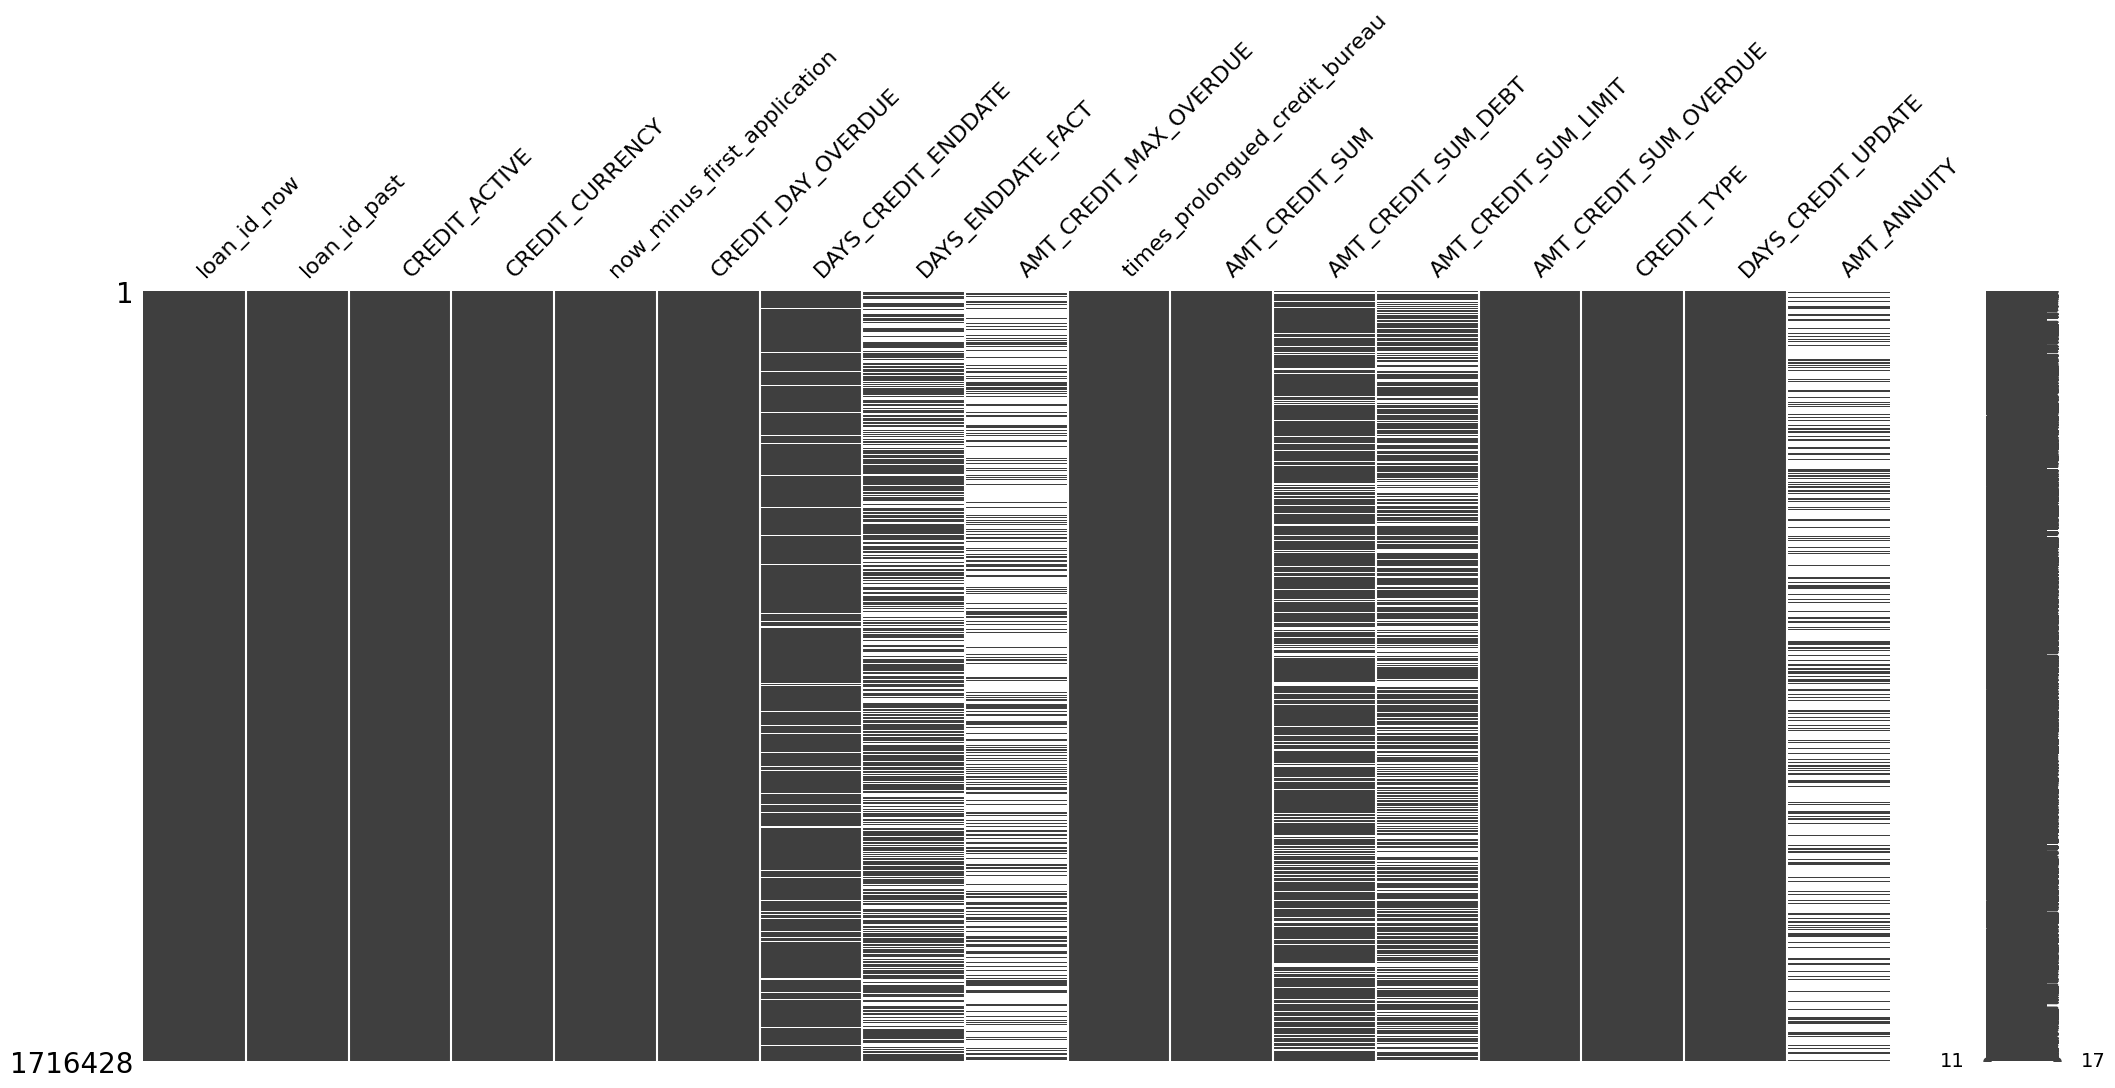

In [11]:
msno.matrix(bureau)

In [9]:
# 2 variables have more than 50% of their data as missing, so we will remove those columns from the dataset
bureau_na = bureau.drop(columns = ["AMT_ANNUITY","AMT_CREDIT_MAX_OVERDUE"])

In [10]:
# Lets check the number of missing values for categorical variables
# We have to include times_prolongued_credit_bureau because with more values it could be considered as numeric
# but it seems to be explained only with 10 values
categorical = bureau_na[["CREDIT_ACTIVE","CREDIT_CURRENCY","CREDIT_TYPE","times_prolongued_credit_bureau"]]
# Get proportion of NA per column
categorical.isna().sum()/len(categorical)

CREDIT_ACTIVE                     0.0
CREDIT_CURRENCY                   0.0
CREDIT_TYPE                       0.0
times_prolongued_credit_bureau    0.0
dtype: float64

Categorical variales dont have missing values. Lets create a solution in case they have missing values

In [11]:
# This is to insert random nan data 
prueba = categorical.mask(np.random.random(categorical.shape) < .2)
prueba.isna().sum()/len(prueba)

CREDIT_ACTIVE                     0.199863
CREDIT_CURRENCY                   0.200370
CREDIT_TYPE                       0.199497
times_prolongued_credit_bureau    0.200101
dtype: float64

In [ ]:
# For the categories which have between 5 and 50% of Nans, we replace Nan values with a new category
prueba[['CREDIT_ACTIVE', 'CREDIT_CURRENCY', "CREDIT_TYPE"]] = prueba[['CREDIT_ACTIVE', 'CREDIT_CURRENCY', "CREDIT_TYPE"]].fillna(value="UNKNOWN")

The next code is to substitute NAs

In [ ]:
#merge two DataFrames
#df1 = df1.merge(df2, on='team', how='left')

#drop original DataFrame columns
#df1.drop(['points_x', 'assists_x'], inplace=True, axis=1)

#rename columns
#df1.rename(columns={'points_y':'points','assists_y':'assists'}, inplace=True))

As the categorical variables doesn't contain missing values no imputation or dataframe merging is needed but it would be necessary in the other case. Now lets check for the numeric variables:

In [11]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_var = bureau_na.select_dtypes(include=numerics)

In [12]:
num_var.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1716428 entries, 0 to 1716427
Data columns (total 12 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   loan_id_now                     int64  
 1   loan_id_past                    int64  
 2   now_minus_first_application     int64  
 3   CREDIT_DAY_OVERDUE              int64  
 4   DAYS_CREDIT_ENDDATE             float64
 5   DAYS_ENDDATE_FACT               float64
 6   times_prolongued_credit_bureau  int64  
 7   AMT_CREDIT_SUM                  float64
 8   AMT_CREDIT_SUM_DEBT             float64
 9   AMT_CREDIT_SUM_LIMIT            float64
 10  AMT_CREDIT_SUM_OVERDUE          float64
 11  DAYS_CREDIT_UPDATE              int64  
dtypes: float64(6), int64(6)
memory usage: 170.2 MB


In [13]:
num_var.isna().sum()/len(num_var)

loan_id_now                       0.000000
loan_id_past                      0.000000
now_minus_first_application       0.000000
CREDIT_DAY_OVERDUE                0.000000
DAYS_CREDIT_ENDDATE               0.061496
DAYS_ENDDATE_FACT                 0.369170
times_prolongued_credit_bureau    0.000000
AMT_CREDIT_SUM                    0.000008
AMT_CREDIT_SUM_DEBT               0.150119
AMT_CREDIT_SUM_LIMIT              0.344774
AMT_CREDIT_SUM_OVERDUE            0.000000
DAYS_CREDIT_UPDATE                0.000000
dtype: float64

In [19]:
# Lets check the 2 variables with highest percentage of NA
bureau_na["AMT_CREDIT_SUM_LIMIT"].describe()

count    1.124648e+06
mean     6.229515e+03
std      4.503203e+04
min     -5.864061e+05
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.705600e+06
Name: AMT_CREDIT_SUM_LIMIT, dtype: float64

In [20]:
bureau_na["DAYS_ENDDATE_FACT"].describe()

count    1.082775e+06
mean    -1.017437e+03
std      7.140106e+02
min     -4.202300e+04
25%     -1.489000e+03
50%     -8.970000e+02
75%     -4.250000e+02
max      0.000000e+00
Name: DAYS_ENDDATE_FACT, dtype: float64

It seems that our data contains some outliers based on the description so we should check the distribution of each point of the data

It takes a lot of time to plot the histogram or distribution for each variable. We will try with the ECDF (the empirical distribution function) and a boxplot to check distributions. 

<AxesSubplot:xlabel='DAYS_ENDDATE_FACT'>

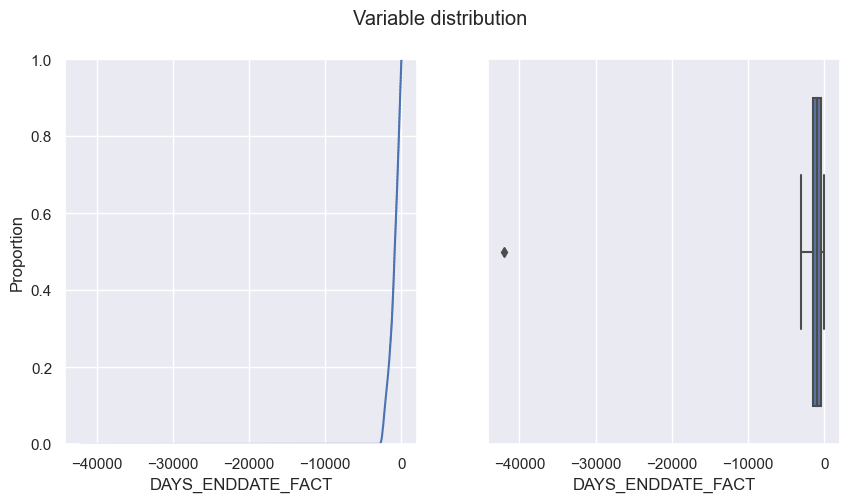

In [36]:
variables_distribution_plots(bureau_na,["loan_id_now", "loan_id_past"])

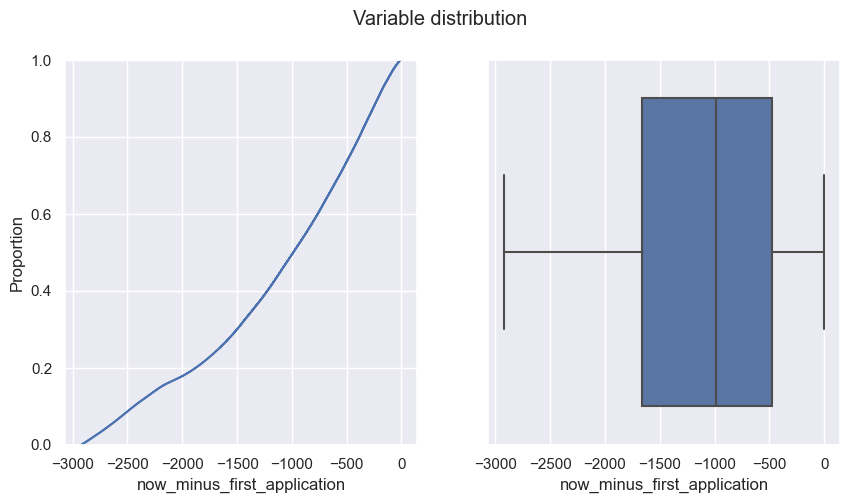

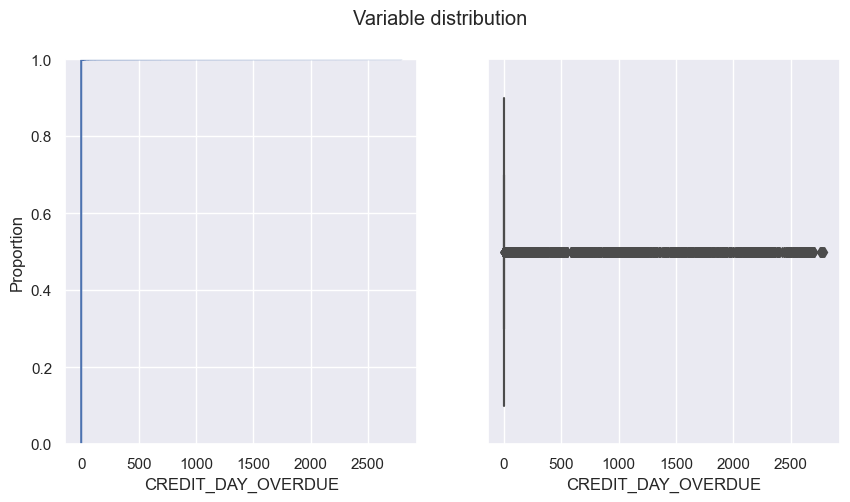

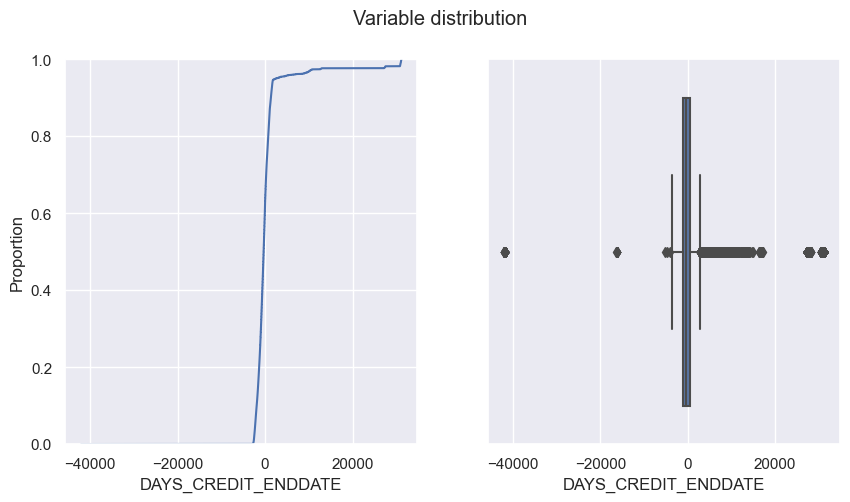

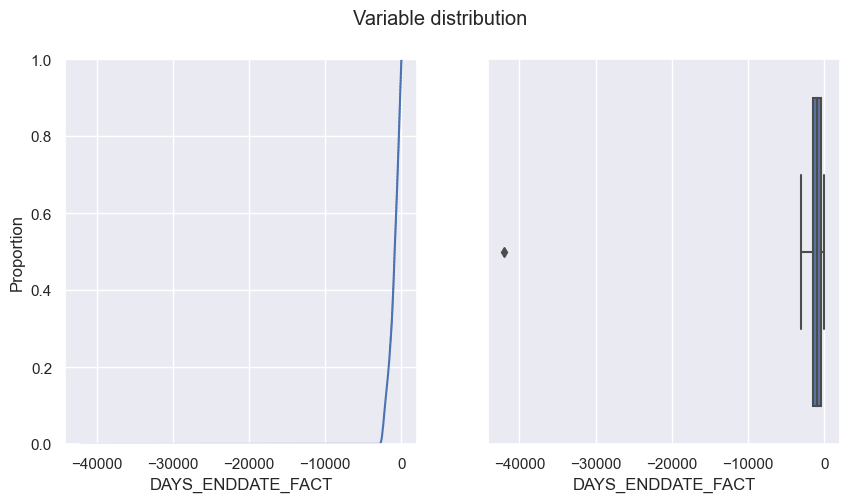

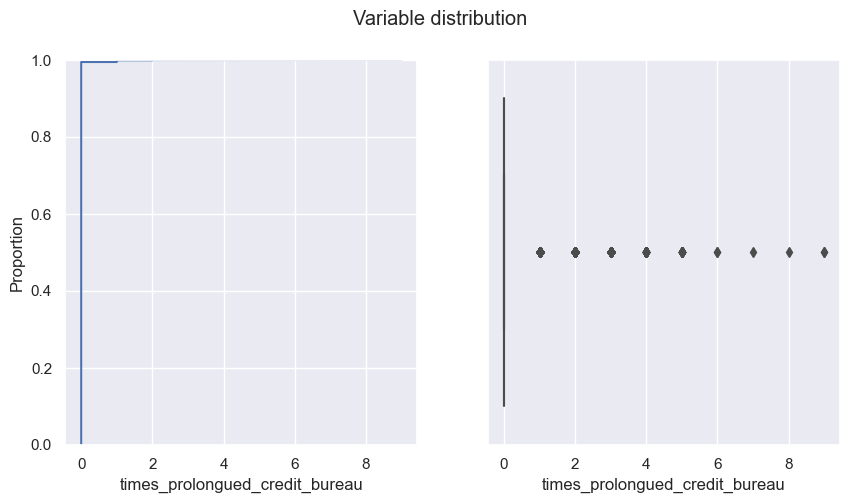

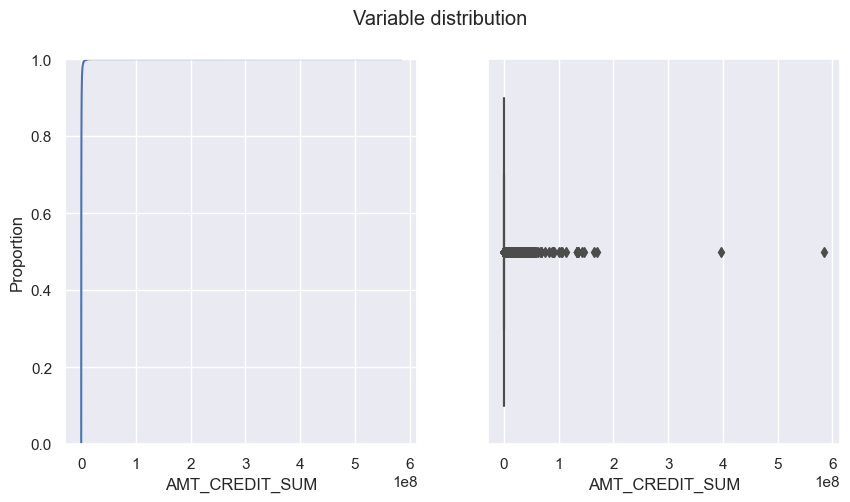

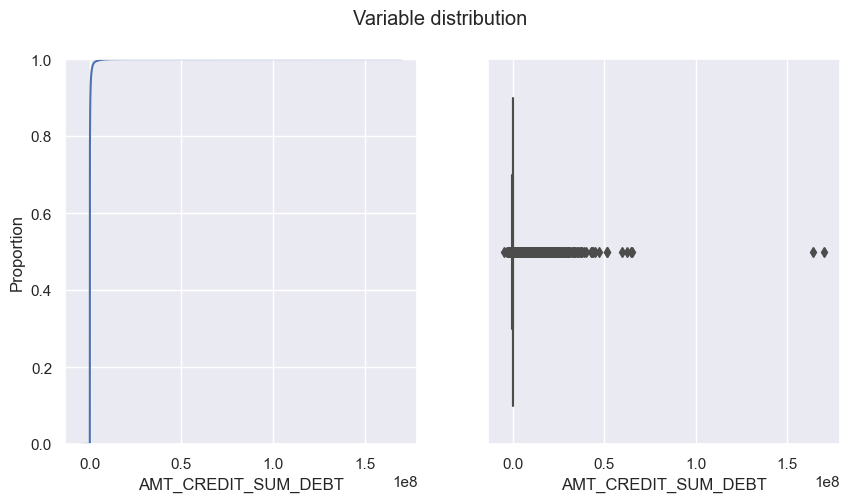

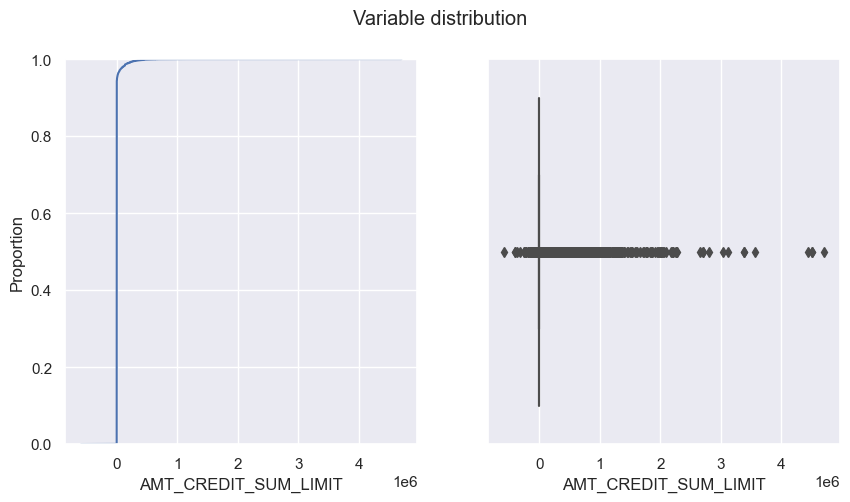

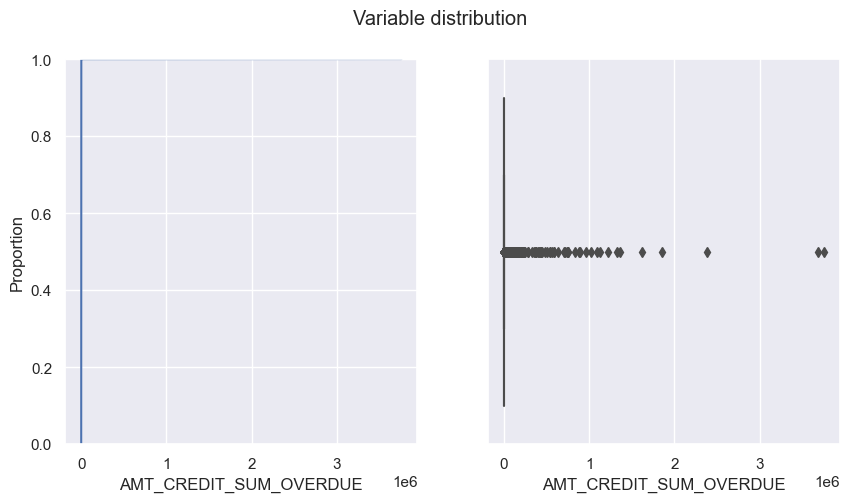

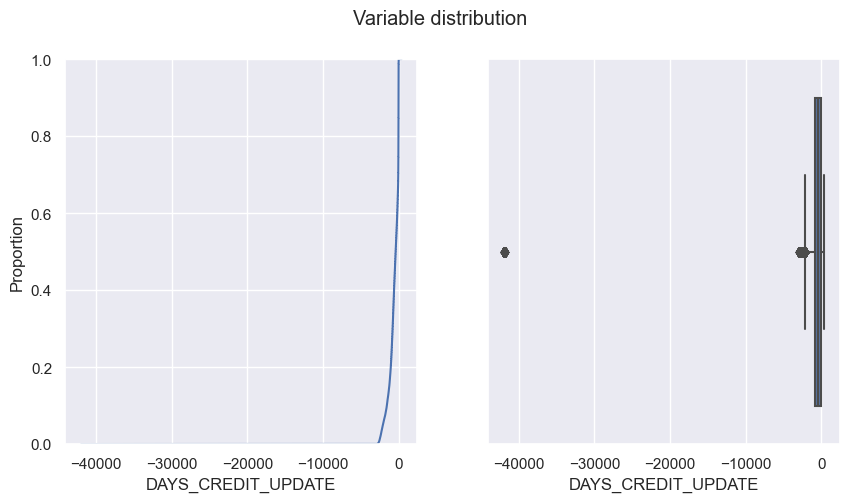

The charts help us to identify many outliers and, in addition, that the variable "times_prolongued_credit_bureau" should be classified as categorical.

In [42]:
for col in ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', "CREDIT_TYPE", "times_prolongued_credit_bureau"]:
    bureau_na[col] = bureau_na[col].astype("category")

Viendo las distribuciones, se puede comprobar que hay presentes outliers muy pronunciados por lo que procedemos a tratarlas mediante la imputación de un valor no superior al percentil 90 de la distribución ni inferior al percentil 10

In [ ]:
bur_clean = cap_outliers_percentiles(bureau_na, ["loan_id_now", "loan_id_past"], perc1=10, perc2=90)

Now we can plot again to see if the problem is solved

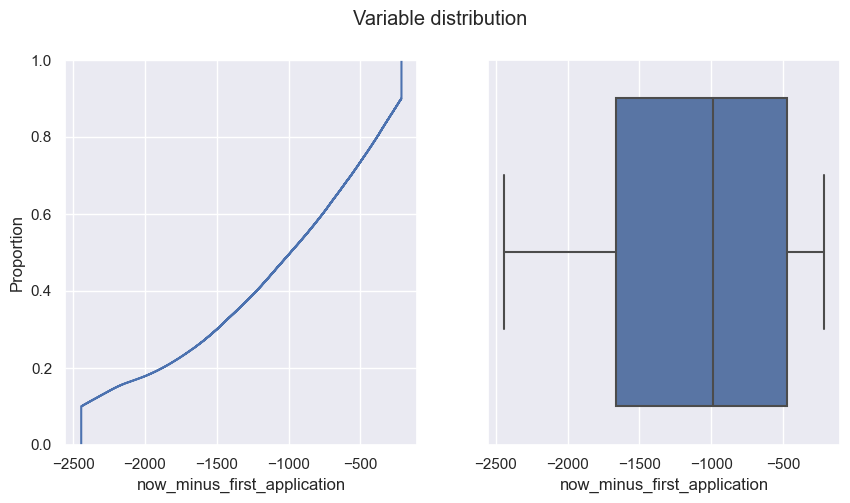

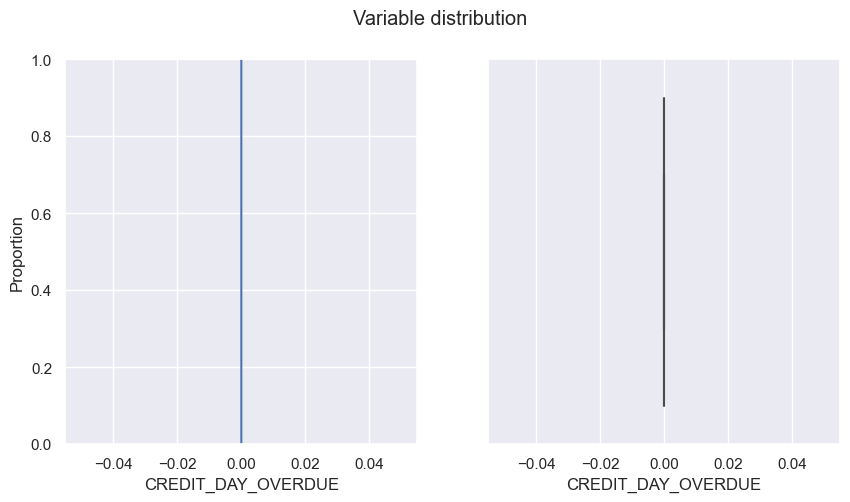

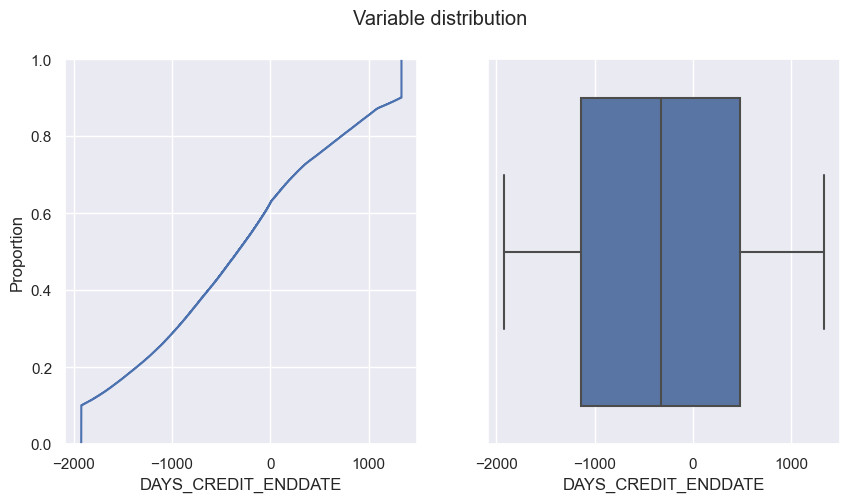

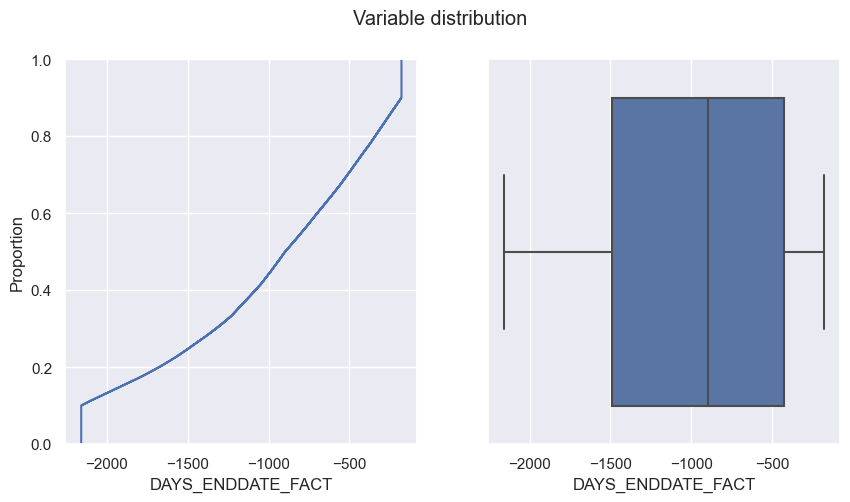

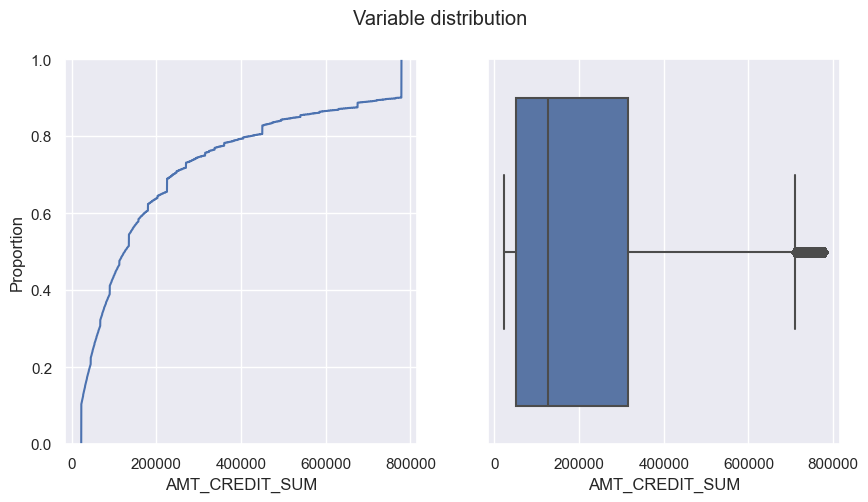

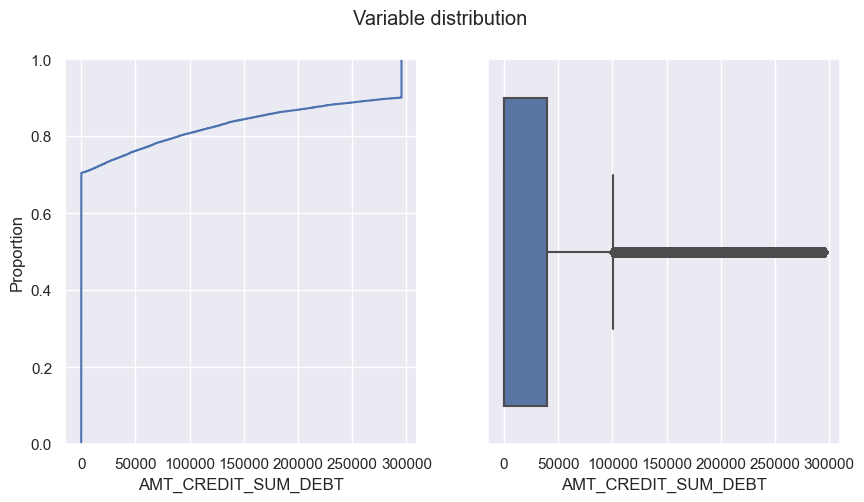

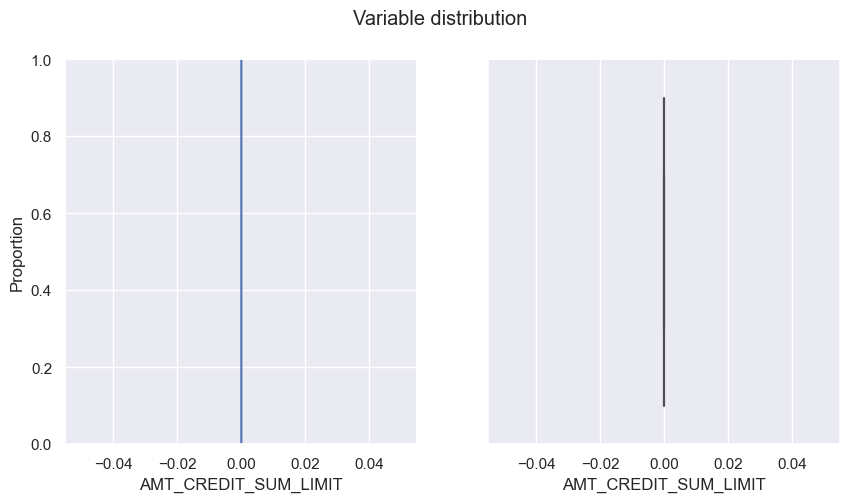

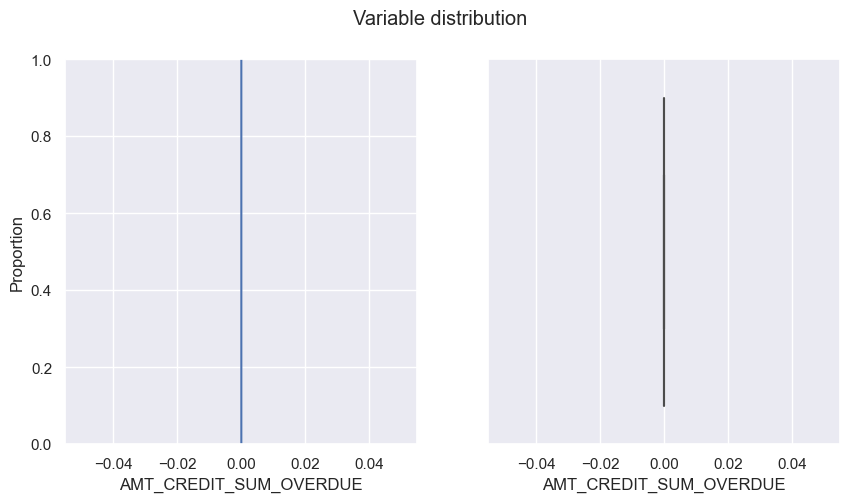

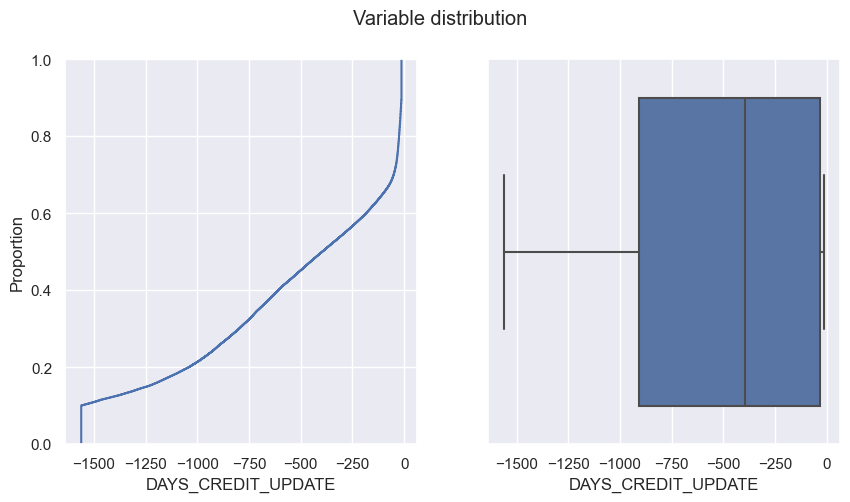

In [59]:
variables_distribution_plots(bur_clean,["loan_id_now", "loan_id_past"])

For some variables, the treatment has worked, but for otherswe can see that the boxplot and distribution are just a line in 0. They are related with customer credit limits and amounts overdue in the past. As they have a huge proportion of the same value, we can delete them from the model becuse they dont add more information to separate and clasify rows. We will apply a function to remove the data if the proportion of the same values is larger than a certain specified amount.

In [76]:
print(bur_clean["CREDIT_DAY_OVERDUE"].describe())
print(bureau_na["CREDIT_DAY_OVERDUE"].describe())

cos = bureau_na["CREDIT_DAY_OVERDUE"].value_counts(normalize = True).nlargest(1)[0]

count    1716428.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: CREDIT_DAY_OVERDUE, dtype: float64
count    1.716428e+06
mean     8.181666e-01
std      3.654443e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.792000e+03
Name: CREDIT_DAY_OVERDUE, dtype: float64


In [75]:
def remove_non_informqative_columns(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_result = df.copy()
    
    for c in list(df_result.columns):
        if (df_result[c].dtype in numerics) and (c not in vars_to_skip):
            # Computing 10th, 90th percentiles and replacing the outliers
            floor_percentile = np.nanpercentile(df_result[c], perc1)
            cap_percentile = np.nanpercentile(df_result[c], perc2)
            # print(tenth_percentile, ninetieth_percentile)b = np.where(sample<tenth_percentile, tenth_percentile, sample)
            df_result[c] = np.where(df_result[c] > cap_percentile, cap_percentile, df_result[c])
            df_result[c] = np.where(df_result[c] < floor_percentile, floor_percentile, df_result[c])

0.997543153572419

In [26]:
lol=pd.DataFrame(cosa)
lol.describe()
bureau_na.to_csv("cosa.csv")

In [24]:
no_outliers = cap_outliers_percentiles(bureau_na, ["loan_id_now", "loan_id_past"])

count    1.716428e+06
mean    -1.128616e+03
std      7.397130e+02
min     -2.443000e+03
25%     -1.666000e+03
50%     -9.870000e+02
75%     -4.740000e+02
max     -2.150000e+02
Name: now_minus_first_application, dtype: float64
count    1716428.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: CREDIT_DAY_OVERDUE, dtype: float64
count    1.610875e+06
mean     5.105174e+02
std      4.994220e+03
min     -4.206000e+04
25%     -1.138000e+03
50%     -3.300000e+02
75%      4.740000e+02
max      3.119900e+04
Name: DAYS_CREDIT_ENDDATE, dtype: float64
count    1.082775e+06
mean    -1.017437e+03
std      7.140106e+02
min     -4.202300e+04
25%     -1.489000e+03
50%     -8.970000e+02
75%     -4.250000e+02
max      0.000000e+00
Name: DAYS_ENDDATE_FACT, dtype: float64
count    1716428.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max           

,loan_id_now,loan_id_past,CREDIT_ACTIVE,CREDIT_CURRENCY,now_minus_first_application,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,times_prolongued_credit_bureau,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE
0,215354,5714462,Closed,currency 1,-497.0,0.0,-153.0,-153.0,0.0,91323.00,0.0,NaN,0.0,Consumer credit,-131.0
1,215354,5714463,Active,currency 1,-215.0,0.0,1075.0,NaN,0.0,225000.00,171342.0,NaN,0.0,Credit card,-20.0
2,215354,5714464,Active,currency 1,-215.0,0.0,528.0,NaN,0.0,464323.50,NaN,NaN,0.0,Consumer credit,-16.0
3,215354,5714465,Active,currency 1,-215.0,0.0,NaN,NaN,0.0,90000.00,NaN,NaN,0.0,Credit card,-16.0
4,215354,5714466,Active,currency 1,-629.0,0.0,1197.0,NaN,0.0,2700000.00,NaN,NaN,0.0,Consumer credit,-21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-215.0,0.0,-30.0,NaN,0.0,11250.00,11250.0,0.0,0.0,Microloan,-19.0
1716424,100044,5057754,Closed,currency 1,-2443.0,0.0,-2433.0,-2493.0,0.0,38130.84,0.0,0.0,0.0,Consumer credit,-1561.0
1716425,100044,5057762,Closed,currency 1,-1809.0,0.0,-1628.0,-970.0,0.0,15570.00,NaN,NaN,0.0,Consumer credit,-967.0
1716426,246829,5057770,Closed,currency 1,-1878.0,0.0,-1513.0,-1513.0,0.0,36000.00,0.0,0.0,0.0,Consumer credit,-1508.0


<Figure size 1500x1000 with 0 Axes>

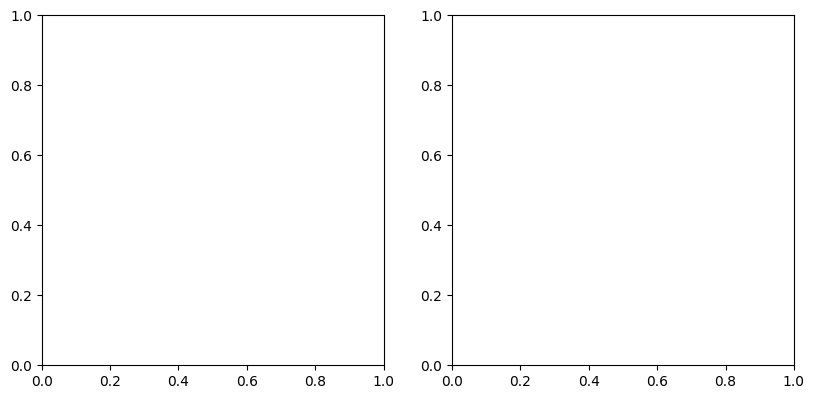

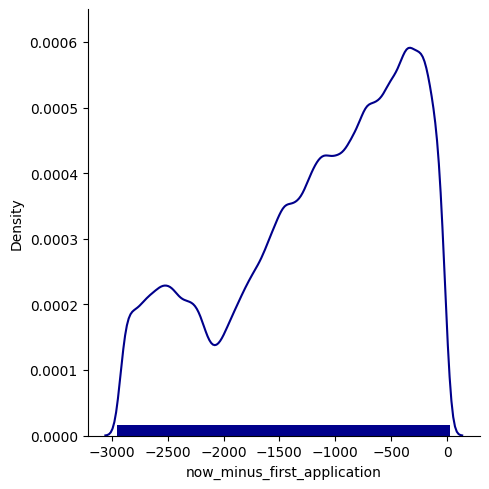

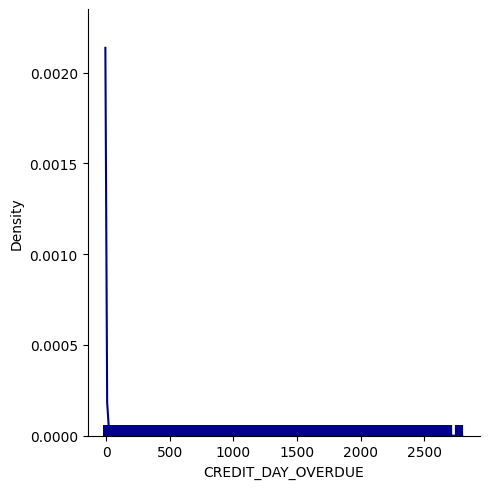

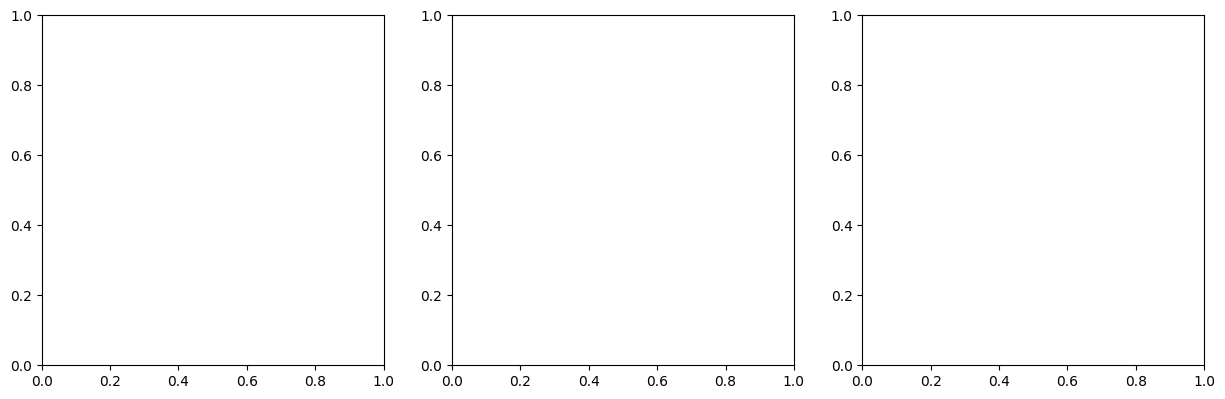

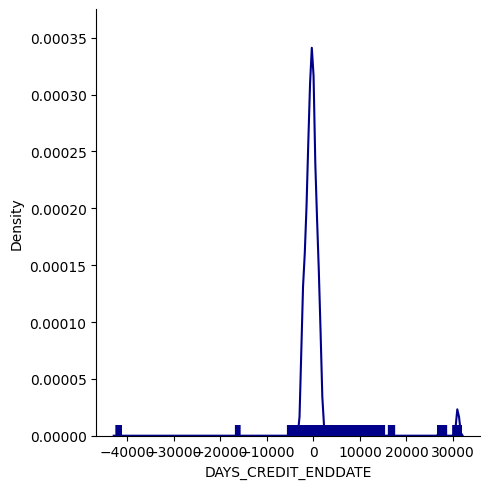

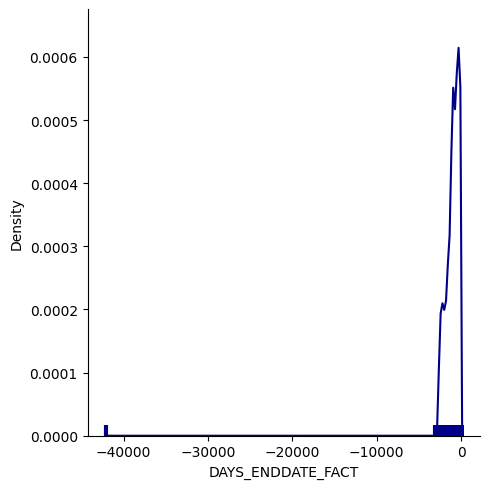

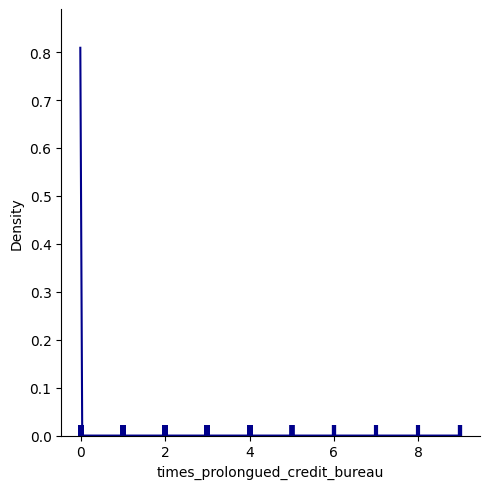

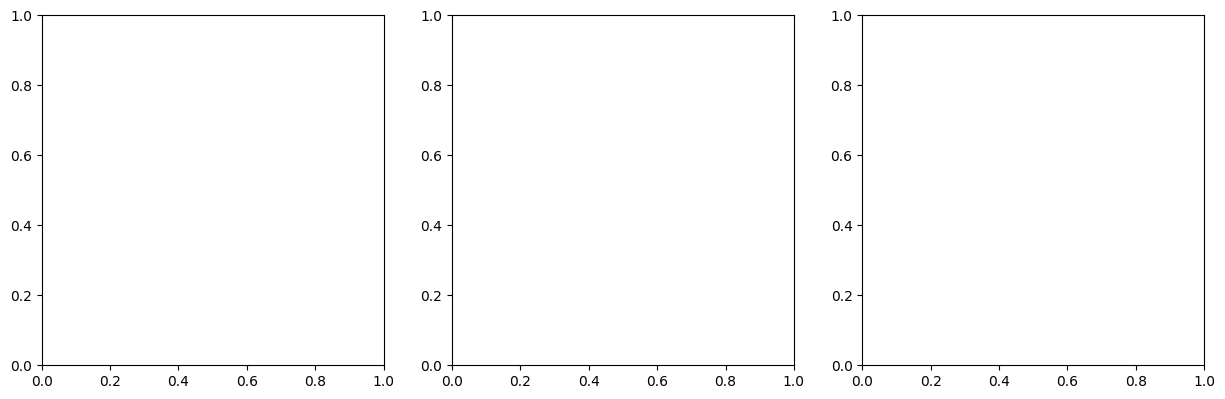

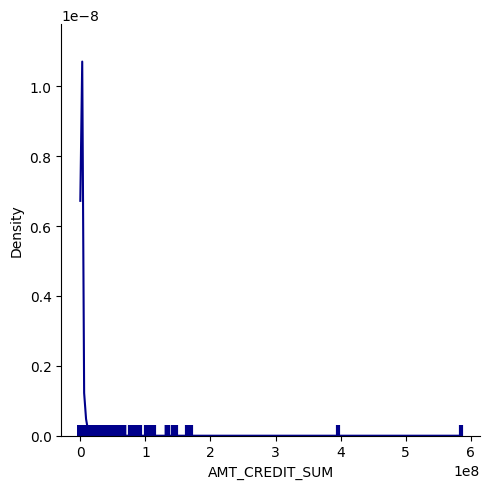

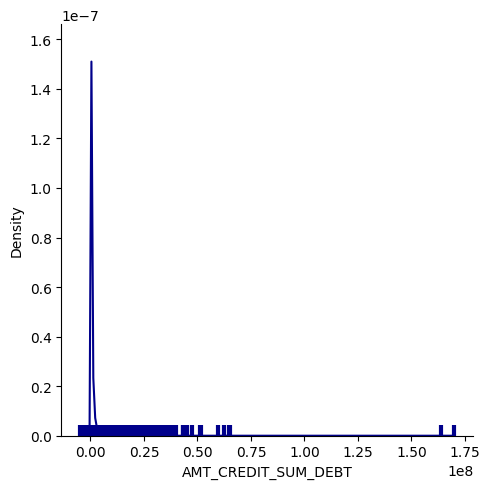

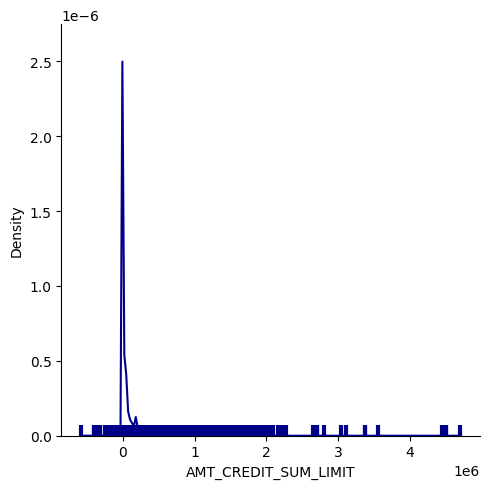

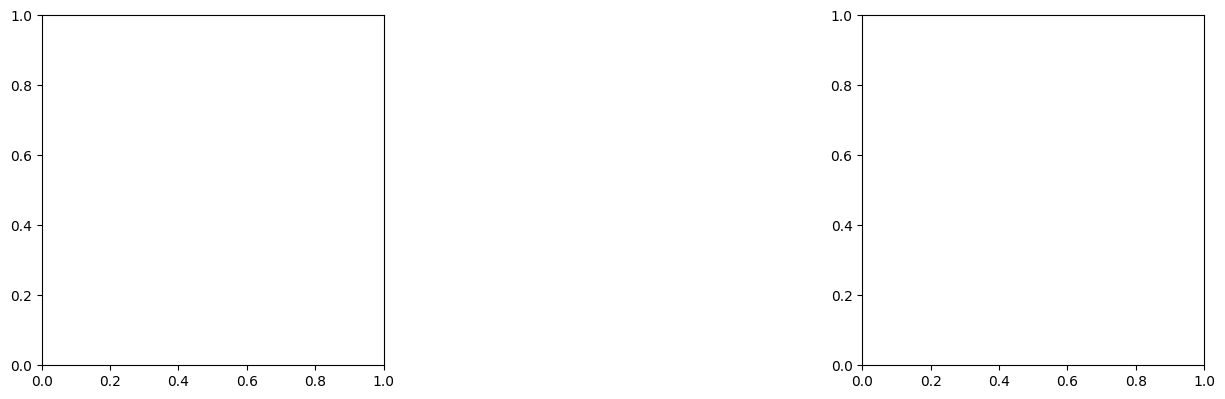

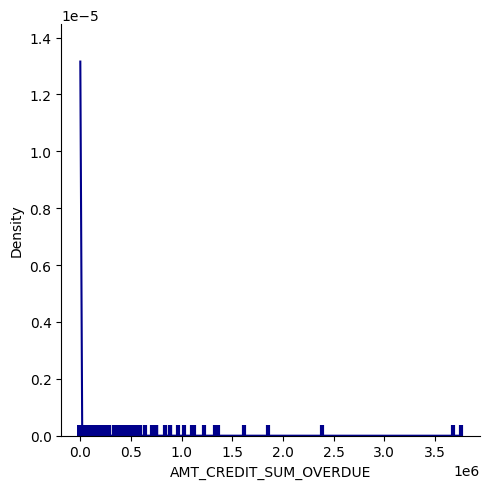

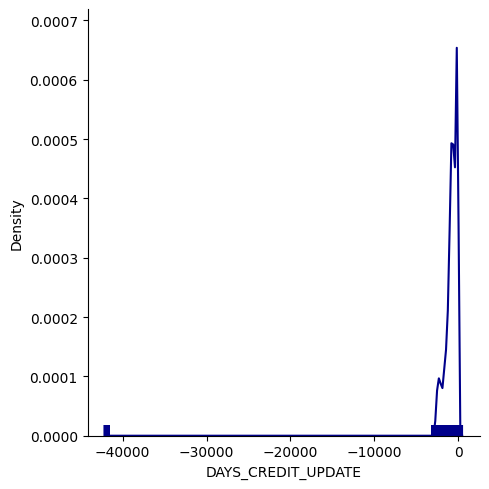

<Figure size 1500x1000 with 0 Axes>

In [59]:
variables_distribution_plots(df=bureau_na, vars_to_skip=['loan_id_now', 'loan_id_past'])

Both variables appear to have suited values and the presence of missing is because of a lack of information indeed.
We will use MICE imputation and after we will visualize the imputed data
Inthe MICE imputation, we cant include categorical variables to impute the data, MICE is only for numerical variables

In [21]:
# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

# Insert 
df_mice = bureau_na.filter(['DAYS_ENDDATE_FACT','CREDIT_DAY_OVERDUE','times_prolongued_credit_bureau','AMT_CREDIT_SUM',
                    'AMT_CREDIT_SUM_OVERDUE','DAYS_CREDIT_UPDATE','now_minus_first_application','AMT_CREDIT_SUM_LIMIT'], axis=1).copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

In [22]:
num_var.isna().sum()/len(num_var)

loan_id_now                       0.000000
loan_id_past                      0.000000
now_minus_first_application       0.000000
CREDIT_DAY_OVERDUE                0.000000
DAYS_CREDIT_ENDDATE               0.061496
DAYS_ENDDATE_FACT                 0.369170
times_prolongued_credit_bureau    0.000000
AMT_CREDIT_SUM                    0.000008
AMT_CREDIT_SUM_DEBT               0.150119
AMT_CREDIT_SUM_LIMIT              0.344774
AMT_CREDIT_SUM_OVERDUE            0.000000
DAYS_CREDIT_UPDATE                0.000000
dtype: float64

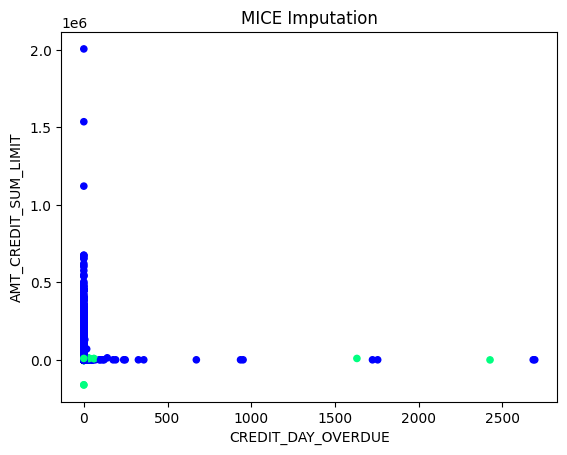

In [23]:
fig = plt.Figure()
null_values = bureau_na['AMT_CREDIT_SUM_LIMIT'].isnull().sample(n=30000, random_state = 1)
my_sample = df_mice_imputed.sample(n=30000, random_state = 1)
fig = my_sample.plot(x='CREDIT_DAY_OVERDUE',
                           y='AMT_CREDIT_SUM_LIMIT',
                           kind='scatter',
                           c=null_values,
                           cmap='winter',
                           title='MICE Imputation',
                           colorbar=False)

<AxesSubplot:xlabel='AMT_CREDIT_SUM_LIMIT', ylabel='Count'>

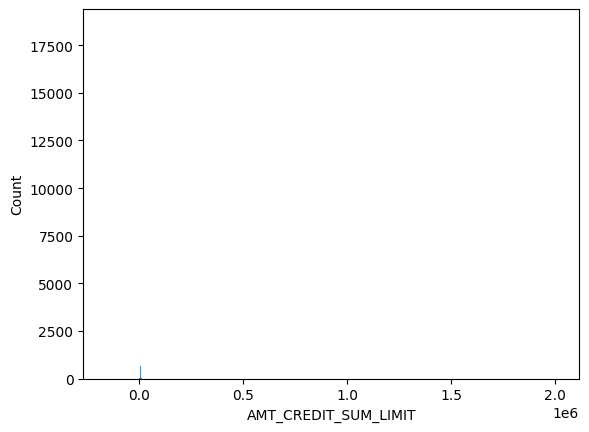

In [24]:
sns.histplot(data=my_sample, x="AMT_CREDIT_SUM_LIMIT")

In [25]:
df_mice_imputed["AMT_CREDIT_SUM_LIMIT"].describe()

count    1.716428e+06
mean     6.030964e+03
std      3.648108e+04
min     -5.864061e+05
25%      0.000000e+00
50%      0.000000e+00
75%      4.592366e+03
max      4.705600e+06
Name: AMT_CREDIT_SUM_LIMIT, dtype: float64

In [26]:
df_mice_imputed["AMT_CREDIT_SUM_LIMIT"].describe()

count    1.716428e+06
mean     6.030964e+03
std      3.648108e+04
min     -5.864061e+05
25%      0.000000e+00
50%      0.000000e+00
75%      4.592366e+03
max      4.705600e+06
Name: AMT_CREDIT_SUM_LIMIT, dtype: float64

<AxesSubplot:xlabel='AMT_CREDIT_SUM_LIMIT', ylabel='Count'>

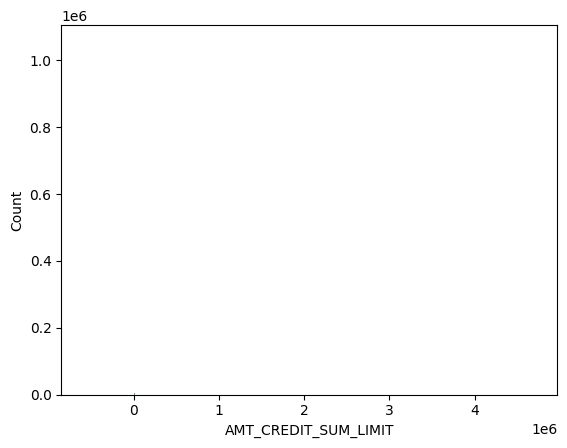

In [27]:
sns.histplot(data=df_mice_imputed, x="AMT_CREDIT_SUM_LIMIT")

In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np
np.random.seed(1)
random_data = np.random.randn(50000,2)  * 20 + 20

clf = IsolationForest( behaviour = 'new', max_samples=100, random_state = 1, contamination= 'auto')
preds = clf.fit_predict(random_data)
preds